# Imports

In [1]:
import os
os.chdir("../../")

In [2]:
import copy
import glob
import math
import yaml

from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, matthews_corrcoef
import seaborn as sns 

from cids.util import misc_funcs as misc
from cids.data import SCVIC_CIDS_CLASSES, SCVIC_CIDS_CLASSES_INV

# SCVIC

## Load Data

In [3]:
def load_configs(paths, base=True):
    configs = {}
    for path in paths:
        with open(path, "r") as f:
            print(f"Loading {path}")
            config = yaml.safe_load(f)
        key = "model_type" if base else "id"
        configs[config["experiment"][key]] = config
    return configs

cids_config_binary_paths = glob.glob(os.path.join(misc.root(), "config/01_supervision/leave-x-out-binary/CIDS/single/*.yaml"))
mlp_config_binary_paths = glob.glob(os.path.join(misc.root(), "config/01_supervision/leave-x-out-binary/MLP/single/*.yaml"))
cmlp_config_binary_paths = glob.glob(os.path.join(misc.root(), "config/01_supervision/leave-x-out-binary/CMLP/single/*.yaml"))
rf_config_paths = glob.glob(os.path.join(misc.root(), "config/01_supervision/leave-x-out-binary/RF/single/*.yaml"))

unsupervised_config_paths = [g for g in glob.glob(os.path.join(misc.root(), "config/02_anomaly_detection/baseline/*.yaml"))  if "OPTC" not in g]


cids_binary_configs = load_configs(cids_config_binary_paths, base=False)
mlp_binary_configs = load_configs(mlp_config_binary_paths, base=False)
cmlp_binary_configs = load_configs(cmlp_config_binary_paths, base=False)
rf_configs = load_configs(rf_config_paths, base=False)
unsupervised_configs = load_configs(unsupervised_config_paths, base=False)

Loading /opt/gildemeister/gildemeister-implementation/config/01_supervision/leave-x-out-binary/CIDS/single/DoS-Slowloris.yaml
Loading /opt/gildemeister/gildemeister-implementation/config/01_supervision/leave-x-out-binary/CIDS/single/DoS-Hulk.yaml
Loading /opt/gildemeister/gildemeister-implementation/config/01_supervision/leave-x-out-binary/CIDS/single/DDoS-HOIC.yaml
Loading /opt/gildemeister/gildemeister-implementation/config/01_supervision/leave-x-out-binary/CIDS/single/DoS-SlowHTTPTest.yaml
Loading /opt/gildemeister/gildemeister-implementation/config/01_supervision/leave-x-out-binary/CIDS/single/BOT.yaml
Loading /opt/gildemeister/gildemeister-implementation/config/01_supervision/leave-x-out-binary/CIDS/single/FTP.yaml
Loading /opt/gildemeister/gildemeister-implementation/config/01_supervision/leave-x-out-binary/CIDS/single/DDoS-LOIC-UDP.yaml
Loading /opt/gildemeister/gildemeister-implementation/config/01_supervision/leave-x-out-binary/CIDS/single/SSH.yaml
Loading /opt/gildemeister/gi

In [4]:
def load_confusion(key, config, base_path, binary=False, source="test"):
    confusion_matrix = np.zeros((len(config["experiment"]["seed"]), len(SCVIC_CIDS_CLASSES), 2 if binary else len(SCVIC_CIDS_CLASSES)))
    experiment_config = config["experiment"]
    for j in range(len(config["experiment"]["seed"])):
        confusion_matrix_seed = pd.read_csv(os.path.join(base_path, f"{experiment_config["id"]}-{j}/{source}_confusion.csv"), index_col=0, header=0)
        confusion_matrix[j] = confusion_matrix_seed.to_numpy()
    
    return confusion_matrix

In [7]:
mlp_binary_confusion_matrices = {}
cmlp_binary_confusion_matrices = {}
cids_binary_confusion_matrices = {}
rf_binary_confusion_matrices = {}
unsupervised_confusion_matrices = {}

source = "test" # One of train | val | test
for k, config in mlp_binary_configs.items():
    experiment_config = config["experiment"]
    mlp_binary_confusion_matrices[k] = load_confusion(k, config,base_path = os.path.join(misc.root(), f"results/01_supervision/leaf-x-out-binary/{config["dataset"]["ds_name"]}/{experiment_config["model_type"]}/{experiment_config["id"]}/"), binary=True, source=source)
for k, config in cmlp_binary_configs.items():
    experiment_config = config["experiment"]
    cmlp_binary_confusion_matrices[k] = load_confusion(k, config,base_path = os.path.join(misc.root(), f"results/01_supervision/leaf-x-out-binary/{config["dataset"]["ds_name"]}/{experiment_config["model_type"]}/{experiment_config["id"]}/"), binary=True, source=source)
for k, config in cids_binary_configs.items():
    experiment_config = config["experiment"]
    cids_binary_confusion_matrices[k] = load_confusion(k, config,base_path = os.path.join(misc.root(), f"results/01_supervision/leaf-x-out-binary/{config["dataset"]["ds_name"]}/{experiment_config["model_type"]}/{experiment_config["id"]}/"), binary=True, source=source)
for k, config in rf_configs.items():
    experiment_config = config["experiment"]
    rf_binary_confusion_matrices[k] = load_confusion(k, config,base_path = os.path.join(misc.root(), f"results/01_supervision/leaf-x-out-binary/{config["dataset"]["ds_name"]}/{experiment_config["model_type"]}/{experiment_config["id"]}/"), binary=True, source=source)
for k, config in unsupervised_configs.items():
    experiment_config = config["experiment"]
    unsupervised_confusion_matrices[k] = load_confusion(k, config, base_path = os.path.join(misc.root(), f"results/02_anomaly-detection/baseline/{config["dataset"]["ds_name"]}/{experiment_config["model_type"]}/{experiment_config["id"]}/"), binary=True, source=source)
print(mlp_binary_confusion_matrices.keys())

dict_keys(['DoS-Slowloris', 'DoS-Hulk', 'DDoS-HOIC', 'DoS-SlowHTTP', 'BOT', 'FTP', 'DDoS-LOIC-UDP', 'SSH', 'DoS-GoldenEye', 'DDoS-LOIC-HTTP'])


In [6]:
mlp_binary_confusion_probabilities = {}
for k, confusion in mlp_binary_confusion_matrices.items():
    mlp_binary_confusion_probabilities[k] = confusion / confusion.sum(axis=2, keepdims=True)

cmlp_binary_confusion_probabilities = {}
for k, confusion in cmlp_binary_confusion_matrices.items():
    cmlp_binary_confusion_probabilities[k] = confusion / confusion.sum(axis=2, keepdims=True)

cids_binary_confusion_probabilities = {}
for k, confusion in cids_binary_confusion_matrices.items():
    cids_binary_confusion_probabilities[k] = confusion / confusion.sum(axis=2, keepdims=True)

rf_binary_confusion_probabilities = {}
for k, confusion in rf_binary_confusion_matrices.items():
    rf_binary_confusion_probabilities[k] = confusion / confusion.sum(axis=2, keepdims=True)

unsupervised_confusion_probabilities = {}
for k, confusion in unsupervised_confusion_matrices.items():
    unsupervised_confusion_probabilities[k] = confusion / confusion.sum(axis=2, keepdims=True)

## Plotting single class comparison

In [8]:
def calculate_f1_scores(confusion_matrices, confusion_class, debug=False):
    f1_scores = []
    for cm, k in zip(confusion_matrices, confusion_class):
            
        TP = cm[:, k, 1]   # True Positives
        FP = cm[:, 0, 1]   # False Positives
        FN = cm[:, k, 0]   # False Negatives
        if debug:
            print(TP, FP, FN, k)
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        
        f1 = 2 * (precision * recall) / (precision + recall + 1e-16)
        f1_scores.append(f1)
    return np.array(f1_scores)

def calculate_accuracy(confusion_matrices, confusion_class):
    accs = []
    for cm, k in zip(confusion_matrices, confusion_class):
        accs.append(cm[:, k, 1] / cm[:, k].sum(axis=1))

    return np.array(accs)

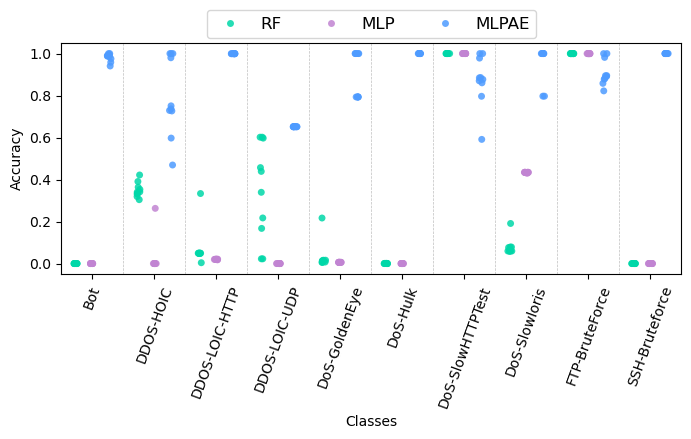

In [9]:
colours = ["#00D7A8",
    "#C184D2", "#4E9BFF"
]
groups = ["RF", "MLP", "MLPAE"]
models_supervised = [(mlp_binary_confusion_matrices, mlp_binary_configs), (rf_binary_confusion_matrices, rf_configs)]
keys = list(mlp_binary_configs.keys())
keys.sort()
classes = [SCVIC_CIDS_CLASSES[mlp_binary_configs[k]["dataset"]["exclude"][0]] for k in keys]

# Prepare data for seaborn
data = []
for i, (model_conf, config) in enumerate(models_supervised):
    acc_score_list = calculate_accuracy([model_conf[k] for k in keys], classes)
    for j, (c, accs) in enumerate(zip(classes, acc_score_list)):
        for acc in accs:
            data.append({
                "Class": SCVIC_CIDS_CLASSES_INV[c],
                "Accuracy": acc,
                "Model": groups[i]
            })

# MLPAE
acc_score_list = calculate_accuracy(len(classes) * [unsupervised_confusion_matrices["MLPAE-1"]], classes)
for j, (c, accs) in enumerate(zip(classes, acc_score_list)):
    for acc in accs:
        data.append({
            "Class": SCVIC_CIDS_CLASSES_INV[c],
            "Accuracy": acc,
            "Model": groups[2]
        })

df = pd.DataFrame(data)

plt.figure(figsize=(8, 3))
ax = sns.stripplot(data=df, x="Class", y="Accuracy", hue="Model", palette=colours, dodge=True, jitter=True, alpha=0.85)
ax.tick_params(axis='x', rotation=70)

# Add vertical grid lines at each class
for i in range(len(df["Class"].unique()) + 1):
    ax.axvline(i - 0.5, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Move legend above plot
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=len(groups), fontsize=12)
plt.ylabel('Accuracy')
plt.xlabel('Classes')
#plt.grid()
plt.savefig(os.path.join(misc.root(), "plots/leave-x-out-binary-network-acc.pdf"), bbox_inches="tight")
plt.show()

In [28]:
from sklearn.metrics.pairwise import cosine_similarity

def get_per_class_feature_importance(rf, X, y, num_classes):
    """
    Estimate per-class feature importances by averaging feature importances
    from trees weighted by the number of samples of each class in their leaves.
    """
    n_features = X.shape[1]
    class_importances = np.zeros((num_classes, n_features))
    for c in range(num_classes):
        # Mask for samples of class c
        mask = (y == c)
        if not np.any(mask):
            continue
        # Fit a new RF on only class c to get importances (approximation)
        # Alternatively, use the original RF and weight importances by class presence in leaves
        # Here, we use the original RF's feature_importances_ as a proxy
        class_importances[c] = rf.feature_importances_
    return class_importances

def compare_left_out_class_feature_importance(rf, X, y, left_out_class, class_names):
    num_classes = len(class_names)
    class_importances = get_per_class_feature_importance(rf, X, y, num_classes)
    left_out_idx = left_out_class
    similarities = []
    for c in range(num_classes):
        if c == left_out_idx:
            similarities.append(-np.inf)
            continue
        sim = cosine_similarity(
            class_importances[left_out_idx].reshape(1, -1),
            class_importances[c].reshape(1, -1)
        )[0, 0]
        similarities.append(sim)
    most_similar_idx = np.argmax(similarities)
    return most_similar_idx, similarities

In [29]:
for key, config in rf_configs.items():
     rf = ... # Load your trained RF model for this experiment
     X_train, y_train = ... # Load your training data for this experiment
     left_out_class = SCVIC_CIDS_CLASSES[config["dataset"]["exclude"][0]]
     most_similar_idx, similarities = compare_left_out_class_feature_importance(
         rf, X_train, y_train, left_out_class, list(SCVIC_CIDS_CLASSES.keys())
     )
     print(f"For left out class {left_out_class}, most similar class is {most_similar_idx} ({list(SCVIC_CIDS_CLASSES.keys())[most_similar_idx]})")

TypeError: cannot unpack non-iterable ellipsis object

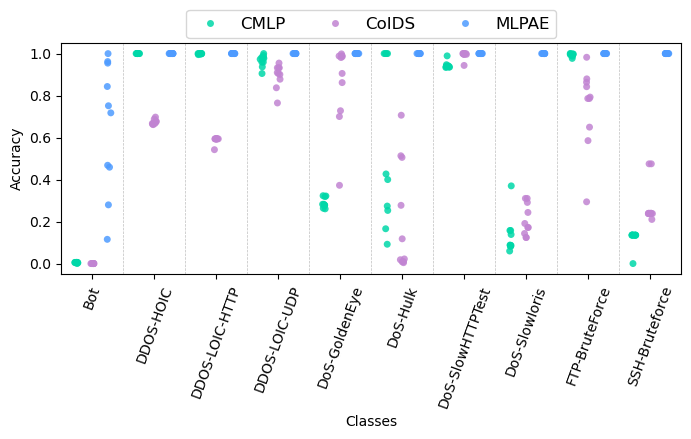

In [10]:
colours = ["#00D7A8",
    "#C184D2", "#4E9BFF"
]
groups = ["CMLP", "CoIDS", "MLPAE"]
models_supervised = [(cmlp_binary_confusion_matrices, cmlp_binary_configs), (cids_binary_confusion_matrices, cids_binary_configs)]
keys = list(cids_binary_configs.keys())
keys.sort()
classes = [SCVIC_CIDS_CLASSES[mlp_binary_configs[k]["dataset"]["exclude"][0]] for k in keys]

# Prepare data for seaborn
data = []
for i, (model_conf, config) in enumerate(models_supervised):
    acc_score_list = calculate_accuracy([model_conf[k] for k in keys], classes)
    for j, (c, accs) in enumerate(zip(classes, acc_score_list)):
        for acc in accs:
            data.append({
                "Class": SCVIC_CIDS_CLASSES_INV[c],
                "Accuracy": acc,
                "Model": groups[i]
            })

# MLPAE
acc_score_list = calculate_accuracy(len(classes) * [unsupervised_confusion_matrices["MLPAE-2"]], classes)
for j, (c, accs) in enumerate(zip(classes, acc_score_list)):
    for acc in accs:
        data.append({
            "Class": SCVIC_CIDS_CLASSES_INV[c],
            "Accuracy": acc,
            "Model": groups[-1]
        })

df = pd.DataFrame(data)

plt.figure(figsize=(8, 3))
ax = sns.stripplot(data=df, x="Class", y="Accuracy", hue="Model", palette=colours, dodge=True, jitter=True, alpha=0.85)
ax.tick_params(axis='x', rotation=70)

# Add vertical grid lines at each class
for i in range(len(df["Class"].unique()) + 1):
    ax.axvline(i - 0.5, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Move legend above plot
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=len(groups), fontsize=12)
plt.ylabel('Accuracy')
plt.xlabel('Classes')
#plt.grid()
plt.savefig(os.path.join(misc.root(), "plots/leave-x-out-binary-networkhost-acc.pdf"), bbox_inches="tight")
plt.show()

DoS-Slowloris [0.05966587 0.07875895 0.07637232 0.07875895 0.05966587 0.05966587
 0.05966587 0.19093079 0.05966587 0.05966587]
DoS-Hulk [0.         0.00100301 0.         0.         0.         0.
 0.00125376 0.         0.         0.        ]
DDoS-HOIC [0.35301449 0.33158191 0.36362081 0.33492998 0.39072314 0.31911826
 0.30425963 0.42180894 0.34015983 0.34147951]
DoS-SlowHTTP [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
BOT [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
FTP [0.99979227 0.99979227 0.99979227 0.99979227 0.99979227 0.99979227
 0.99979227 0.99979227 0.99979227 0.99979227]
DDoS-LOIC-UDP [0.33936652 0.16742081 0.43891403 0.02262443 0.59728507 0.60180995
 0.02262443 0.21719457 0.60180995 0.45701357]
SSH [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
DoS-GoldenEye [0.00582242 0.21688501 0.01601164 0.01310044 0.01310044 0.00727802
 0.01601164 0.00582242 0.00727802 0.01018923]
DDoS-LOIC-HTTP [0.04923949 0.04923949 0.04923949 0.3335052  0.04923949 0.04923949
 0.0476927  0.04923949 0.04923949 0.00395291]
DoS-Slowloris [0.124

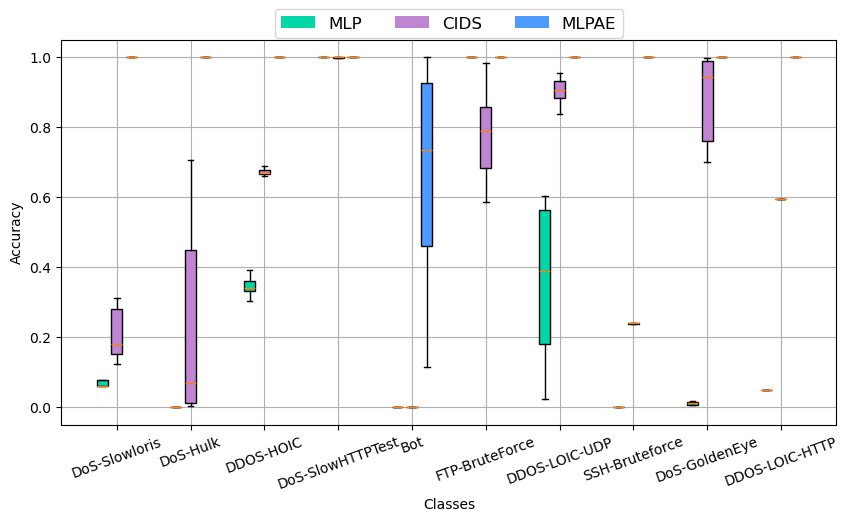

In [20]:
colours = ["#00D7A8",
    "#C184D2", "#4E9BFF"
]
groups = ["MLP", "CIDS", "MLPAE"]
keys = list(mlp_binary_configs.keys())
classes = [SCVIC_CIDS_CLASSES[mlp_binary_configs[k]["dataset"]["exclude"][0]] for k in keys]
fig = plt.figure(figsize=(10, 5))
pos = np.asarray([i*1000 for i in range(1, len(mlp_binary_configs) + 1)])
for i, (model_conf, config) in enumerate([(mlp_binary_confusion_matrices, mlp_binary_configs), (cids_binary_confusion_matrices, cids_binary_configs)]):
    acc_score_list = calculate_accuracy([model_conf[k] for k in keys], classes)
    for j, k in enumerate(keys):
        print(k, acc_score_list[j])


    bp = plt.boxplot(acc_score_list.T, positions=pos + (i * 200 - 200), widths=150, patch_artist=True, showfliers=False)
    for box in bp['boxes']:
        box.set(facecolor=colours[i])
# Prepare data for boxplot: transposing so that we have classes on x-axis and different matrices as separate groups

acc_score_list = calculate_accuracy(len(classes) * [unsupervised_confusion_matrices["MLPAE-2"]], classes)

bp = plt.boxplot(acc_score_list.T, positions=pos + (2 * 200 - 200), widths=150, patch_artist=True, showfliers=False)
for box in bp['boxes']:
    box.set(facecolor=colours[2])

legend_elements = []
for i in range(3):
    legend_elements.append(Patch(facecolor=colours[i], label=groups[i]))
plt.legend(handles=legend_elements, fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=len(groups))
# Set x-ticks labels 
plt.xticks(pos, [id["dataset"]["exclude"][0] for id in mlp_binary_configs.values()], rotation=20)
plt.ylabel('Accuracy')
plt.xlabel('Classes')
plt.grid()
plt.show()

/tmp/ipykernel_1449267/3361409948.py:33: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.stripplot(data=df, x="Class", y="Accuracy", hue="Model", palette=colours, dodge=True, jitter=True, alpha=0.7)


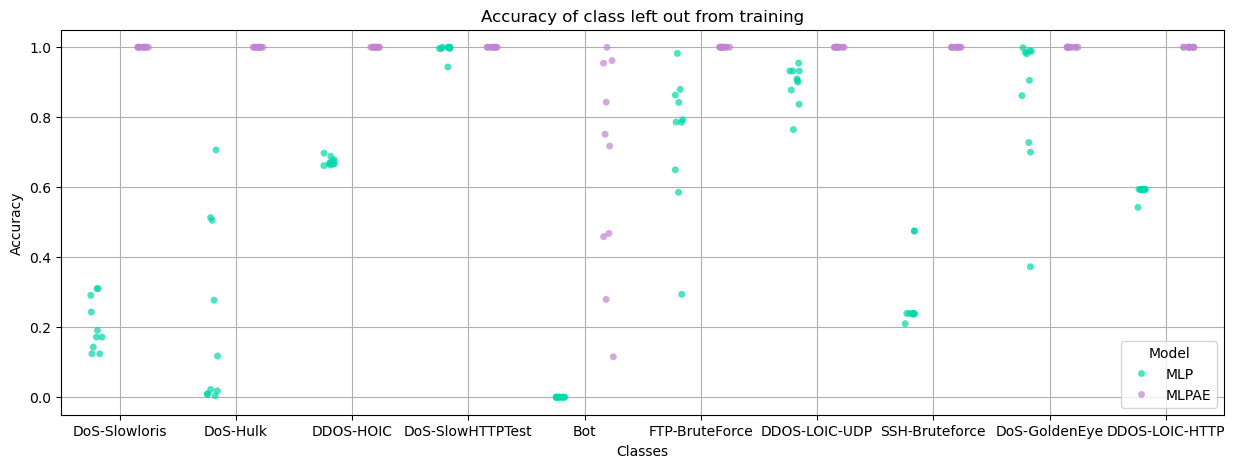

In [25]:

colours = ["#00D7A8", "#C184D2", "#4E9BFF"]
groups = ["MLP", "CIDS", "MLPAE"]
keys = list(mlp_binary_configs.keys())
classes = [SCVIC_CIDS_CLASSES[mlp_binary_configs[k]["dataset"]["exclude"][0]] for k in keys]
pos = np.asarray([i for i in range(len(mlp_binary_configs))])

# Prepare data for seaborn
data = []
for i, (model_conf, config) in enumerate(models_supervised):
    acc_score_list = calculate_accuracy([model_conf[k] for k in keys], classes)
    for j, (c, accs) in enumerate(zip(classes, acc_score_list)):
        for acc in accs:
            data.append({
                "Class": SCVIC_CIDS_CLASSES_INV[c],
                "Accuracy": acc,
                "Model": groups[i]
            })

# MLPAE
acc_score_list = calculate_accuracy(len(classes) * [unsupervised_confusion_matrices["MLPAE-2"]], classes)
for j, (c, accs) in enumerate(zip(classes, acc_score_list)):
    for acc in accs:
        data.append({
            "Class": SCVIC_CIDS_CLASSES_INV[c],
            "Accuracy": acc,
            "Model": groups[2]
        })


df = pd.DataFrame(data)

plt.figure(figsize=(15, 5))
sns.stripplot(data=df, x="Class", y="Accuracy", hue="Model", palette=colours, dodge=True, jitter=True, alpha=0.7)
plt.title("Accuracy of class left out from training")
plt.ylabel('Accuracy')
plt.xlabel('Classes')
plt.legend(title="Model")
plt.grid()
plt.show()

# OpTC

In [63]:
config_binary_paths = [g for g in glob.glob(os.path.join(misc.root(), "config/01_supervision/baseline-binary/*.yaml")) if "OPTC" in g]
# rf_config_paths = glob.glob(os.path.join(misc.root(), "config/01_supervision/leaf-x-out/RF/*.yaml"))

unsupervised_config_paths = [g for g in glob.glob(os.path.join(misc.root(), "config/02_anomaly_detection/baseline/*.yaml"))  if "OPTC" not in g]


binary_configs = load_configs(config_binary_paths, base=False)
unsupervised_configs = load_configs(unsupervised_config_paths, base=False)

Loading /opt/gildemeister/gildemeister-implementation/config/01_supervision/baseline-binary/MLP-OPTC-T-1.yaml
Loading /opt/gildemeister/gildemeister-implementation/config/01_supervision/baseline-binary/MLP-OPTC-2.yaml
Loading /opt/gildemeister/gildemeister-implementation/config/01_supervision/baseline-binary/MLP-OPTC-1.yaml
Loading /opt/gildemeister/gildemeister-implementation/config/01_supervision/baseline-binary/MLP-OPTC-T-2.yaml
Loading /opt/gildemeister/gildemeister-implementation/config/02_anomaly_detection/baseline/MLPAE-1.yaml
Loading /opt/gildemeister/gildemeister-implementation/config/02_anomaly_detection/baseline/MLPAE-2.yaml


In [67]:
binary_confusion_matrices = {}
unsupervised_confusion_matrices = {}

source = "validation" # One of train | val | test
for k, config in binary_configs.items():
    experiment_config = config["experiment"]
    binary_confusion_matrices[k] = load_confusion(k, config,base_path = os.path.join(misc.root(), f"results/01_supervision/baseline-binary/{config["dataset"]["name"]}/{experiment_config["model_type"]}/{experiment_config["id"]}/"), binary=True, source=source)
for k, config in unsupervised_configs.items():
    experiment_config = config["experiment"]
    unsupervised_confusion_matrices[k] = load_confusion(k, config, base_path = os.path.join(misc.root(), f"results/02_anomaly-detection/baseline/{config["dataset"]["ds_name"]}/{experiment_config["model_type"]}/{experiment_config["id"]}/"), binary=True, source=source)


FileNotFoundError: [Errno 2] No such file or directory: '/opt/gildemeister/gildemeister-implementation/results/01_supervision/baseline-binary/OpTC/MLPTransformer/MLP-OPTC-T-1/MLP-OPTC-T-1-0/validation_confusion.csv'